In [45]:
import numpy as np
import torch
import torchvision
from torch import nn
from torch.nn import functional as F

In [72]:
from tqdm.notebook import tqdm

In [78]:
# Define the diffusion function
class DiffusionFunction(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dims+1, dims),
            nn.ReLU(),
            nn.Linear(dims, dims),
            nn.Tanh()
        )
        self.dims = dims

    def forward(self, xt, t, noise):
        noise_t = noise * torch.sqrt(1 - t)
        xt_prime = xt + noise_t
        ft = self.net(torch.cat([xt_prime, t.unsqueeze(0)], dim=0))
        xt_next = xt_prime + (1 - t) * ft
        return xt_next

# Define the Diffusion SCM
class DiffSCM(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.diffusion = DiffusionFunction(dims)

        self.mean = nn.Linear(dims, dims)
        self.var = nn.Sequential(
            nn.Linear(dims, dims),
            nn.Softplus()
        )
        self.dims = dims

    def sample(self, n_samples, device):
        noise = torch.randn(n_samples, self.dims).to(device)
        x0 = torch.randn(n_samples, self.dims).to(device)
        t = torch.linspace(0, 1, n_samples).to(device)

        xt = x0
        for i in range(n_samples):
            xt[i, :] = self.diffusion(xt[i, :], t[i], noise[i, :])
        return xt

    def forward(self, x):
        t = torch.rand(x.shape[0], 1).to(x.device)
        xt = self.sample(x.shape[0], x.device)

        mu = self.mean(xt)
        sigma = self.var(xt)
        eps = torch.randn(x.shape).to(x.device)
        x_prime = mu + sigma * eps

        x_tilde = (1 - t) * x + t * x_prime
        return x_tilde

In [81]:
# Define the training loop
def train_diff_scm(model, data_loader, optimizer, device):
    model.train()
    losses = []
    for batch_idx, (x, _) in tqdm(enumerate(data_loader)):
        x = x.to(device)

        optimizer.zero_grad()
        batch_size = x.shape[0]
        x_bt = torch.reshape(x, (batch_size, -1))
        x_tilde = model(x_bt)
        loss = F.mse_loss(x_tilde, x_bt)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

    return np.mean(losses)

# Set up the training data and model
train_data = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
diff_scm = DiffSCM(784).to('cuda')

# Set up the optimizer and train the model
optimizer = torch.optim.Adam(diff_scm.parameters(), lr=1e-3)
for epoch in range(10):
    loss = train_diff_scm(diff_scm, train_loader, optimizer, 'cuda')
    print(f'Epoch {epoch+1} Loss: {loss:.4f}')

# Save the trained model
torch.save(diff_scm.state_dict(), 'diff_scm_mnist_model.pth')

0it [00:00, ?it/s]

Epoch 1 Loss: 0.0623


0it [00:00, ?it/s]

Epoch 2 Loss: 0.0352


0it [00:00, ?it/s]

Epoch 3 Loss: 0.0332


0it [00:00, ?it/s]

Epoch 4 Loss: 0.0320


0it [00:00, ?it/s]

Epoch 5 Loss: 0.0309


0it [00:00, ?it/s]

Epoch 6 Loss: 0.0297


0it [00:00, ?it/s]

Epoch 7 Loss: 0.0290


0it [00:00, ?it/s]

Epoch 8 Loss: 0.0284


0it [00:00, ?it/s]

Epoch 9 Loss: 0.0282


0it [00:00, ?it/s]

Epoch 10 Loss: 0.0276


In [84]:
train_input = train_data.train_data.view(-1, 1, 28, 28).float()
train_target = train_data.train_labels
test_input = train_data.test_data.view(-1, 1, 28, 28).float()
test_target = train_data.test_labels

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [85]:
train_input[0]

tensor([[[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
     

In [86]:
import matplotlib.pyplot as plt

In [103]:
my_img = train_input[200]

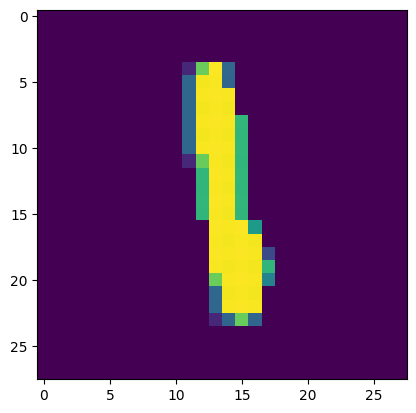

In [104]:
plt.imshow(my_img.permute(1, 2, 0) )

In [105]:
cf = diff_scm(torch.reshape(torch.tensor(my_img), (-1, 784)).to('cuda'))

<ipython-input-105-3d9268ec1ebd>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cf = diff_scm(torch.reshape(torch.tensor(my_img), (-1, 784)).to('cuda'))


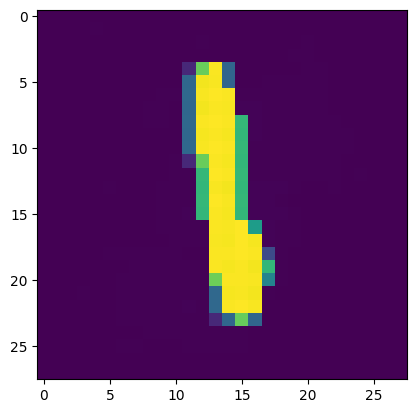

In [106]:
cf = torch.reshape(cf, (28, 28, 1))
plt.imshow(cf.detach().cpu().numpy())

In [107]:
torch.mean(torch.abs(cf - my_img.to('cuda'
)))

tensor(27.9169, device='cuda:0', grad_fn=<MeanBackward0>)

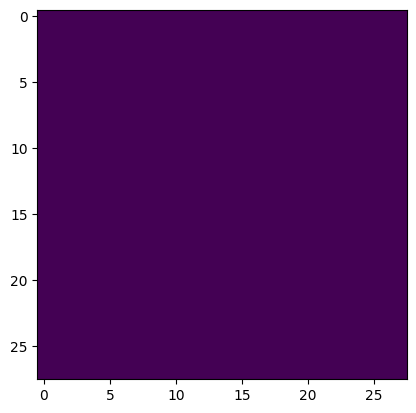

In [108]:
plt.imshow(np.zeros((28, 28, 1)))